In [1]:
import random
from pathlib import Path
from typing import Any, Dict, List, Tuple

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.v2 import functional as F
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModel

## Setup:

In [2]:
# Set images path
train_path = Path("../data/BrainTumor/train")
test_path = Path("../data/BrainTumor/test")
valid_path = Path("../data/BrainTumor/valid")

# Setup class names
CLASSES_NAMES = ["glioma", "meningioma", "pituitary"]

# Define datasets
datasets = {"Train": train_path, "Test": test_path, "Validation": valid_path}

# Load Dinov2 model and transformer
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base", use_fast=True)
dinov2 = AutoModel.from_pretrained("facebook/dinov2-base")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
class CustomDataset(Dataset):
    """Simplified Dataset for object detection"""

    def __init__(self, directory: Path, processor=None) -> None:
        """
        Args:
            directory: Path to images and labels folder
            processor: Image processor (DINOv2 processor)
        """
        super().__init__()
        self.images_dir = directory / "images"
        self.labels_dir = directory / "labels"
        self.processor = processor

        # Get all image files
        self.image_files = list(self.images_dir.glob("*.jpg"))
        self.image_files.sort()

        print(f"Found {len(self.image_files)} images in {self.images_dir}")

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, idx) -> Dict[str, Any]:
        img_path = self.image_files[idx]
        image = Image.open(img_path)

        label_path = self.labels_dir / f"{img_path.stem}.txt"
        labels = self._load_labels(label_path)

        # Process image
        if self.processor:
            processed_image = self.processor(images=image, return_tensors="pt")
            pixel_values = processed_image["pixel_values"].squeeze(0)
        else:
            pixel_values = image

        return {"pixel_values": pixel_values, "labels": labels, "image_path": str(img_path), "original_image": image}

    def _load_labels(self, labels_path: Path) -> List[Dict[str, Any]]:
        """Load labels from text file"""
        labels = []

        with open(labels_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            entries = line.strip().split()
            # Extract class id (first entry)
            class_id = int(entries[0])

            # Extract polygon coordinates
            coordinates = [float(i) for i in entries[1:]]
            x_coords = coordinates[::2]
            y_coords = coordinates[1::2]

            # Get bounding box from polygon vertices
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)

            # Convert to center format
            cx = (x_min + x_max) / 2
            cy = (y_min + y_max) / 2
            width = x_max - x_min
            height = y_max - y_min

            labels.append(
                {"class_id": class_id, "bbox": [cx, cy, width, height], "vertices": list(zip(x_coords, y_coords))}
            )

        return labels

In [4]:
def create_dataloaders(
    train_dir: Path, test_dir: Path, processor, batch_size: int = 16
) -> Tuple[DataLoader, DataLoader]:
    train_dataset = CustomDataset(train_dir, processor)
    test_dataset = CustomDataset(test_dir, processor)

    def collate_fn(batch) -> Dict[str, Any]:
        """Custom collate function to handle variable number of labels"""
        pixel_values = torch.stack([item["pixel_values"] for item in batch])
        labels = [item["labels"] for item in batch]
        image_paths = [item["image_path"] for item in batch]
        original_images = [item["original_image"] for item in batch]

        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "image_paths": image_paths,
            "original_images": original_images,
        }

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_dataloader, test_dataloader

In [5]:
train_dir = Path("../data/BrainTumor/train")
test_dir = Path("../data/BrainTumor/test")

# Create train and test dataloaders
train_dataloader, test_dataloader = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    processor=processor,
    batch_size=16,
)

print(f"Train dataloader: {len(train_dataloader)} batches")
print(f"Test dataloader: {len(test_dataloader)} batches")

Found 2144 images in ../data/BrainTumor/train/images
Found 308 images in ../data/BrainTumor/test/images
Train dataloader: 134 batches
Test dataloader: 20 batches


In [6]:
# Test a single sample to see the data structure
print("\nSample data structure:")
sample_batch = next(iter(train_dataloader))
print(f"Keys: {sample_batch.keys()}")
print(f"Pixel values shape: {sample_batch['pixel_values'].shape}")
print(f"Labels for first batch: {sample_batch['labels']}")


Sample data structure:
Keys: dict_keys(['pixel_values', 'labels', 'image_paths', 'original_images'])
Pixel values shape: torch.Size([16, 3, 224, 224])
Labels for first batch: [[{'class_id': 1, 'bbox': [0.4735376046875, 0.713091921875, 0.2896935937499999, 0.33426183749999994], 'vertices': [(0.5515320328125, 0.7520891359374999), (0.568245125, 0.688022284375), (0.6072423390624999, 0.6685236765625), (0.59888579375, 0.6072423390624999), (0.6183844015625, 0.571030640625), (0.596100278125, 0.5459610031250001), (0.5626740953125, 0.5459610031250001), (0.49582172656249995, 0.5515320328125), (0.44568245156249997, 0.568245125), (0.37604456875, 0.651810584375), (0.37604456875, 0.71030640625), (0.3342618390625, 0.7632311984375), (0.32869080781250004, 0.793871865625), (0.3621169921875, 0.8384401109375), (0.428969359375, 0.8774373265625), (0.4679665734375, 0.880222840625), (0.5041782734375, 0.8523676874999999), (0.5515320328125, 0.7520891359374999)]}], [{'class_id': 1, 'bbox': [0.22841225625, 0.43175

Testing DataLoader...
Batch shape: torch.Size([16, 3, 224, 224])
Original images shape: [640, 640]


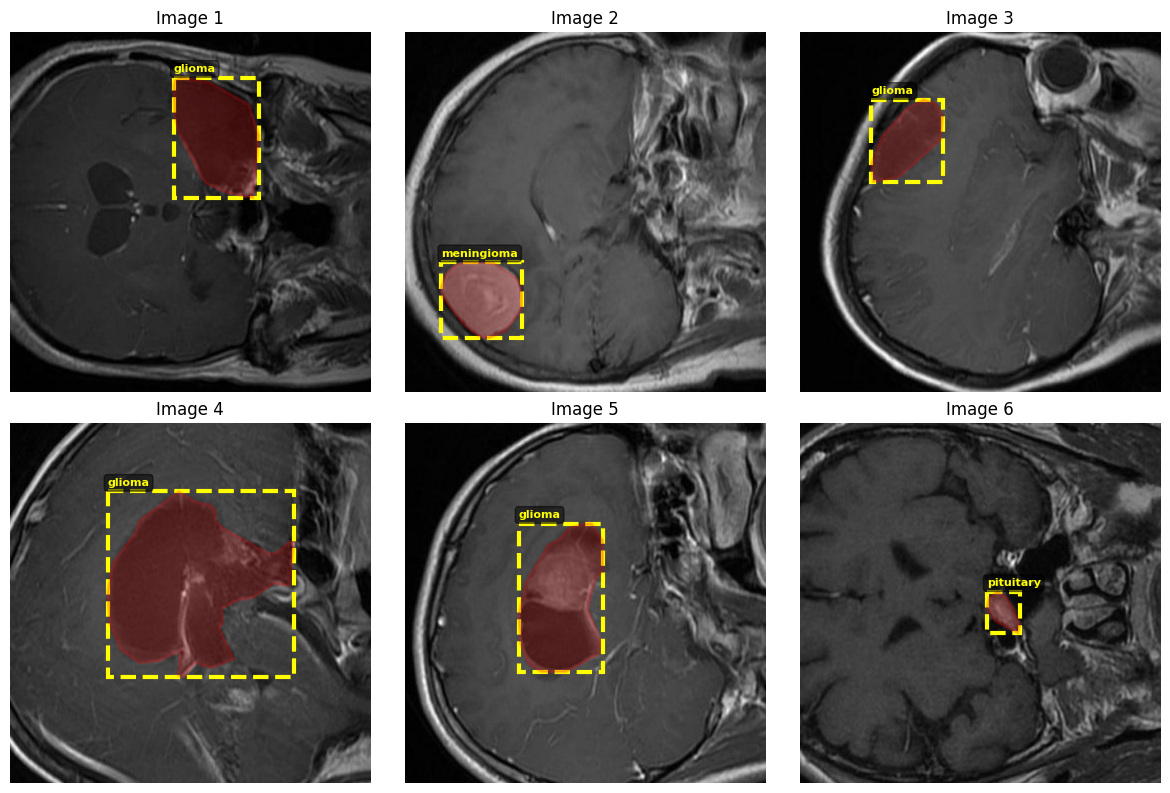

In [7]:
def visualize_batch(dataloader, num_samples=6) -> None:
    """Visualize a batch of images with YOLO bounding boxes"""

    # Get one batch
    batch = next(iter(dataloader))

    pixel_values = batch["pixel_values"]
    labels_list = batch["labels"]
    original_images = batch["original_images"]

    print(f"Batch shape: {pixel_values.shape}")
    print(f"Original images shape: {F.get_size(original_images[0])}")

    # Plot images with bounding boxes
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i in range(min(num_samples, len(original_images))):
        ax = axes[i]
        image = original_images[i]
        labels = labels_list[i]
        img_width, img_height = F.get_size(image)

        # Display image
        ax.imshow(image)
        ax.set_title(f"Image {i + 1}")
        ax.axis("off")

        # Draw bounding boxes
        for label in labels:
            bbox = label["bbox"]
            polygon_points = label["vertices"]
            class_id = label["class_id"]

            # Create rectangle patch
            cx, cy, width, height = bbox

            # Scale to image size
            cx, cy, width, height = cx * img_width, cy * img_height, width * img_width, height * img_height
            polygon_points = [(x * img_width, y * img_height) for x, y in polygon_points]

            # Convert to corner format
            x_min = cx - width / 2
            y_min = cy - height / 2

            # Draw both polygon and bounding box
            rect = patches.Rectangle(
                (x_min, y_min), width, height, linewidth=3, edgecolor="yellow", facecolor="none", linestyle="--"
            )
            polygon = patches.Polygon(
                polygon_points, linewidth=2, edgecolor="red", facecolor="red", alpha=0.2, closed=True
            )
            ax.add_patch(rect)
            ax.add_patch(polygon)

            # Add class label
            ax.text(
                x_min,
                y_min - 10,
                f"{CLASSES_NAMES[class_id]}",
                color="yellow",
                fontsize=8,
                fontweight="bold",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.5),
            )

    plt.tight_layout()
    plt.show()


# Test the dataloader
print("Testing DataLoader...")
visualize_batch(train_dataloader)

## Modify targets for prediction:

In [8]:
def prepare_targets(labels_batch) -> Dict[str, torch.Tensor]:
    """Convert labels to YOLO format (single object per image)"""
    batch_size = len(labels_batch)

    class_targets = torch.zeros(batch_size, dtype=torch.long)
    bbox_targets = torch.zeros(batch_size, 4)

    for batch_idx, labels in enumerate(labels_batch):
        # Take the first (and only) object in each image
        label = labels[0]

        class_targets[batch_idx] = label["class_id"]
        bbox_targets[batch_idx] = torch.tensor(label["bbox"])  # [cx, cy, w, h]

    return {"class_targets": class_targets, "bbox_targets": bbox_targets}

In [9]:
targets = prepare_targets(sample_batch["labels"])
print(f"Class targets shape: {targets['class_targets'].shape}")
print(targets["class_targets"])
print(f"Bounding box targets shape: {targets['bbox_targets'].shape}")
print(targets["bbox_targets"])

Class targets shape: torch.Size([16])
tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0])
Bounding box targets shape: torch.Size([16, 4])
tensor([[0.4735, 0.7131, 0.2897, 0.3343],
        [0.2284, 0.4318, 0.1671, 0.1671],
        [0.7284, 0.2869, 0.3315, 0.3231],
        [0.7061, 0.6435, 0.1365, 0.1838],
        [0.2674, 0.3816, 0.2730, 0.2451],
        [0.3370, 0.3231, 0.3064, 0.2953],
        [0.3106, 0.3259, 0.1866, 0.1448],
        [0.5070, 0.7006, 0.4958, 0.5989],
        [0.6741, 0.3747, 0.2340, 0.2535],
        [0.5418, 0.5836, 0.3983, 0.2758],
        [0.5975, 0.4861, 0.2089, 0.2033],
        [0.0905, 0.6657, 0.1811, 0.2228],
        [0.4276, 0.4958, 0.2145, 0.1337],
        [0.5223, 0.5682, 0.0919, 0.1114],
        [0.7618, 0.5487, 0.2758, 0.4067],
        [0.4540, 0.4735, 0.1950, 0.2451]])


## Base Approach:

In [10]:
dinov2.eval()
# Test a forward pass with a sample batch
with torch.inference_mode():
    outputs = dinov2(sample_batch["pixel_values"])
print(f"Output keys: {outputs.keys()}")
print(f"Output last hidden state: {outputs.last_hidden_state.shape}")
print(f"Output pooler output: {outputs.pooler_output.shape}")

Output keys: odict_keys(['last_hidden_state', 'pooler_output'])
Output last hidden state: torch.Size([16, 257, 768])
Output pooler output: torch.Size([16, 768])


In [11]:
class DINOv2YOLO(nn.Module):
    """YOLO-style detection with DINOv2 backbone"""

    def __init__(
        self,
        model: nn.Module,
        num_classes: int = 3,
        head_dropout: float = 0.1,
        head_hidden_dim: int = 512,
    ) -> None:
        super().__init__()

        self.backbone = model
        self.embed_dim = self.backbone.config.hidden_size  # 768
        self.num_classes = num_classes
        self.head_dropout = head_dropout
        self.head_hidden_dim = head_hidden_dim

        # Detection head (predicts single object per image)
        self.detection_head = nn.Sequential(
            nn.Linear(self.embed_dim, self.head_hidden_dim),
            nn.LayerNorm(self.head_hidden_dim),
            nn.GELU(),
            nn.Dropout(self.head_dropout),
            nn.Linear(self.head_hidden_dim, self.head_hidden_dim // 2),
            nn.LayerNorm(self.head_hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(self.head_dropout * 2),
            nn.Linear(self.head_hidden_dim // 2, self.num_classes + 4),  # classes + bbox coords (cx, cy, w, h)
        )

    def forward(self, pixel_values) -> Dict[str, torch.Tensor]:
        # Extract features using CLS token (global image representation)
        outputs = self.backbone(pixel_values)
        cls_token = outputs.last_hidden_state[:, 0, :]  # [batch, 768]

        # Predict
        preds = self.detection_head(cls_token)  # [batch, num_classes + 4]

        # Split predictions
        class_logits = preds[:, : self.num_classes]  # [batch, num_classes]
        bbox_preds = torch.sigmoid(preds[:, self.num_classes :])  # [batch, 4] - normalized to [0,1]

        return {"class_logits": class_logits, "bbox_preds": bbox_preds}

In [12]:
dinov2_object_detector = DINOv2YOLO(dinov2, num_classes=len(CLASSES_NAMES))
dinov2_object_detector.eval()
with torch.inference_mode():
    outputs = dinov2_object_detector(torch.randn(1, 3, 224, 224))
print(f"Class Logits: {outputs['class_logits'].shape}")
print(f"Bounding Box Predictions: {outputs['bbox_preds'].shape}")
print(
    f"Class logits: {outputs['class_logits']} [batch size: 1, num_patches: 256, num_classes: 4 (3 classes + 1 background)]"
)
print(
    f"Bounding box predictions: {outputs['bbox_preds']} [batch size: 1, num_patches: 256, bounding box: (cx, cy, w, h)]"
)

Class Logits: torch.Size([1, 3])
Bounding Box Predictions: torch.Size([1, 4])
Class logits: tensor([[0.4981, 0.3000, 0.1810]]) [batch size: 1, num_patches: 256, num_classes: 4 (3 classes + 1 background)]
Bounding box predictions: tensor([[0.5992, 0.4107, 0.5150, 0.4593]]) [batch size: 1, num_patches: 256, bounding box: (cx, cy, w, h)]


In [13]:
class DetectionLoss(nn.Module):
    """Simple loss for single object detection"""

    def __init__(self, lambda_class=1.0, lambda_bbox=5.0) -> None:
        super().__init__()
        self.lambda_class = lambda_class
        self.lambda_bbox = lambda_bbox

        self.class_loss_fn = nn.CrossEntropyLoss()
        self.bbox_loss_fn = nn.SmoothL1Loss()

    def forward(
        self, predictions: Dict[str, torch.Tensor], targets: Dict[str, torch.Tensor]
    ) -> Dict[str, torch.Tensor]:
        """
        predictions: dict with 'class_logits' [batch, num_classes] and 'bbox_preds' [batch, 4]
        targets: dict with 'class_targets' [batch] and 'bbox_targets' [batch, 4]
        """
        class_logits = predictions["class_logits"]
        bbox_preds = predictions["bbox_preds"]

        class_targets = targets["class_targets"]
        bbox_targets = targets["bbox_targets"]

        # Classification loss
        class_loss = self.class_loss_fn(class_logits, class_targets)

        # Bounding box loss
        bbox_loss = self.bbox_loss_fn(bbox_preds, bbox_targets)

        # Total loss
        total_loss = self.lambda_class * class_loss + self.lambda_bbox * bbox_loss

        return {
            "total_loss": total_loss,
            "class_loss": class_loss,
            "bbox_loss": bbox_loss,
        }

In [14]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: DetectionLoss,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> Dict[str, float]:
    model.train()
    cumulative_loss = {"total_loss": 0, "class_loss": 0, "bbox_loss": 0}

    for batch in dataloader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"]

        targets = prepare_targets(labels)
        targets = {key: targets[key].to(device) for key in targets}

        # Forward pass
        predictions = model(pixel_values)
        loss_dict = loss_fn(predictions, targets)
        loss = loss_dict["total_loss"]

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate losses
        cumulative_loss = {key: cumulative_loss[key] + loss_dict[key].item() for key in cumulative_loss}

    # Average losses
    avg_loss = {key: cumulative_loss[key] / len(dataloader) for key in cumulative_loss}

    return avg_loss


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: DetectionLoss,
    device: torch.device,
) -> Dict[str, float]:
    model.eval()
    cumulative_loss = {"total_loss": 0, "class_loss": 0, "bbox_loss": 0}

    with torch.inference_mode():
        for batch in dataloader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"]

            targets = prepare_targets(labels)
            targets = {key: targets[key].to(device) for key in targets}

            # Forward pass
            predictions = model(pixel_values)
            loss_dict = loss_fn(predictions, targets)

            # Accumulate losses
            cumulative_loss = {key: cumulative_loss[key] + loss_dict[key].item() for key in cumulative_loss}

    # Average losses
    avg_loss = {key: cumulative_loss[key] / len(dataloader) for key in cumulative_loss}

    return avg_loss


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
) -> Dict[str, List]:
    # Create empty results dictionary
    results = {
        "train_total_loss": [],
        "train_class_loss": [],
        "train_bbox_loss": [],
        "test_total_loss": [],
        "test_class_loss": [],
        "test_bbox_loss": [],
    }
    # Set model to device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss = test_step(model, test_dataloader, loss_fn, device)

        # Print out what's happening
        print(
            f"Epoch: {epoch + 1} | train_loss: {train_loss['total_loss']:.4f} | test_loss: {test_loss['total_loss']:.4f} | "
        )

        # Update results dictionary
        for key in train_loss.keys():
            results[f"train_{key}"].append(train_loss[key])
            results[f"test_{key}"].append(test_loss[key])

    return results

In [24]:
# Create detection model
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using device: {device}")

# Wrap DINOv2 with detection heads
detection_model = DINOv2YOLO(dinov2, num_classes=3)

# Freeze backbone initially (optional)
for param in detection_model.backbone.parameters():
    param.requires_grad = False

# Move to device
detection_model.to(device)

# Initialize loss and optimizer
loss_fn = DetectionLoss(lambda_class=1.0, lambda_bbox=5.0)
optimizer = torch.optim.AdamW(detection_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Training loop
epochs = 5
results = train(
    model=detection_model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=device,
)

Using device: mps


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5611 | test_loss: 0.3259 | 
Epoch: 2 | train_loss: 0.3527 | test_loss: 0.2690 | 
Epoch: 3 | train_loss: 0.2752 | test_loss: 0.3080 | 
Epoch: 4 | train_loss: 0.2621 | test_loss: 0.2166 | 
Epoch: 5 | train_loss: 0.2006 | test_loss: 0.1997 | 


## Spatial Model:

In [26]:
class SpatialDINOv2YOLO(nn.Module):
    """Improved YOLO-style detection with better spatial awareness"""

    def __init__(
        self, model: nn.Module, num_classes: int = 3, head_dropout: float = 0.1, head_hidden_dim: int = 512
    ) -> None:
        super().__init__()

        self.backbone = model
        self.embed_dim = self.backbone.config.hidden_size  # 768
        self.num_classes = num_classes
        self.head_dropout = head_dropout
        self.head_hidden_dim = head_hidden_dim

        # Use both CLS token and spatial pooling for better representation
        self.spatial_pool = nn.AdaptiveAvgPool1d(1)

        # Classification head
        self.class_head = nn.Sequential(
            nn.Linear(self.embed_dim, self.head_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(head_dropout),
            nn.Linear(self.head_hidden_dim // 2, num_classes),
        )

        # Bounding box head
        self.bbox_head = nn.Sequential(
            nn.Linear(self.embed_dim * 2, self.head_hidden_dim),
            nn.ReLU(),
            nn.Dropout(head_dropout * 0.5),  # Less dropout for bbox
            nn.Linear(self.head_hidden_dim, self.head_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(head_dropout * 0.5),
            nn.Linear(self.head_hidden_dim // 2, 4),
        )

    def forward(self, pixel_values: torch.Tensor) -> Dict[str, torch.Tensor]:
        outputs = self.backbone(pixel_values)

        # Get CLS token for classification
        cls_token = outputs.last_hidden_state[:, 0, :]  # [batch, 768]

        # Get spatial features for bbox regression
        patch_tokens = outputs.last_hidden_state[:, 1:, :]  # [batch, 256, 768]
        spatial_features = self.spatial_pool(patch_tokens.transpose(1, 2)).squeeze(-1)  # [batch, 768]

        # Concatenate for bbox prediction
        bbox_features = torch.cat([cls_token, spatial_features], dim=1)  # [batch, 1536]

        # Predictions
        class_logits = self.class_head(cls_token)
        bbox_preds = torch.sigmoid(self.bbox_head(bbox_features))

        return {"class_logits": class_logits, "bbox_preds": bbox_preds}

In [27]:
class SpatialDetectionLoss(nn.Module):
    """Improved loss with better balancing and IoU loss"""

    def __init__(self, lambda_class=1.0, lambda_bbox=2.0, lambda_iou=1.0) -> None:
        super().__init__()
        self.lambda_class = lambda_class
        self.lambda_bbox = lambda_bbox
        self.lambda_iou = lambda_iou

        self.class_loss_fn = nn.CrossEntropyLoss()
        self.bbox_loss_fn = nn.SmoothL1Loss()

    def bbox_iou(self, box1: torch.Tensor, box2: torch.Tensor) -> torch.Tensor:
        """Calculate IoU between two sets of boxes in center format (cx, cy, w, h)"""
        # Convert to corner format
        box1_x1 = box1[:, 0] - box1[:, 2] / 2
        box1_y1 = box1[:, 1] - box1[:, 3] / 2
        box1_x2 = box1[:, 0] + box1[:, 2] / 2
        box1_y2 = box1[:, 1] + box1[:, 3] / 2

        box2_x1 = box2[:, 0] - box2[:, 2] / 2
        box2_y1 = box2[:, 1] - box2[:, 3] / 2
        box2_x2 = box2[:, 0] + box2[:, 2] / 2
        box2_y2 = box2[:, 1] + box2[:, 3] / 2

        # Intersection
        inter_x1 = torch.max(box1_x1, box2_x1)
        inter_y1 = torch.max(box1_y1, box2_y1)
        inter_x2 = torch.min(box1_x2, box2_x2)
        inter_y2 = torch.min(box1_y2, box2_y2)

        inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)

        # Union
        box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
        box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
        union_area = box1_area + box2_area - inter_area

        iou = inter_area / (union_area + 1e-6)
        return iou

    def forward(
        self, predictions: Dict[str, torch.Tensor], targets: Dict[str, torch.Tensor]
    ) -> Dict[str, torch.Tensor]:
        class_logits = predictions["class_logits"]
        bbox_preds = predictions["bbox_preds"]

        class_targets = targets["class_targets"]
        bbox_targets = targets["bbox_targets"]

        # Classification loss
        class_loss = self.class_loss_fn(class_logits, class_targets)

        # Bounding box regression loss
        bbox_loss = self.bbox_loss_fn(bbox_preds, bbox_targets)

        # IoU loss (for better spatial learning)
        iou_scores = self.bbox_iou(bbox_preds, bbox_targets)
        iou_loss = 1 - iou_scores.mean()  # Maximize IoU

        # Total loss with balanced weights
        total_loss = self.lambda_class * class_loss + self.lambda_bbox * bbox_loss + self.lambda_iou * iou_loss

        return {
            "total_loss": total_loss,
            "class_loss": class_loss,
            "bbox_loss": bbox_loss,
            "iou_loss": iou_loss,
        }


In [28]:
# Create improved model
improved_model = SpatialDINOv2YOLO(dinov2, num_classes=3)

# Freeze backbone initially
for param in improved_model.backbone.parameters():
    param.requires_grad = False

improved_model.to(device)

# Improved loss and optimizer
improved_loss_fn = SpatialDetectionLoss(lambda_class=1.0, lambda_bbox=2.0, lambda_iou=1.0)

# Use different learning rates for different parts
backbone_params = list(improved_model.backbone.parameters())
head_params = list(improved_model.class_head.parameters()) + list(improved_model.bbox_head.parameters())

optimizer = torch.optim.AdamW(
    [
        {"params": head_params, "lr": 1e-4},
        # {'params': backbone_params, 'lr': 1e-5}  # Uncomment to unfreeze backbone later
    ],
    weight_decay=1e-3,
)  # Increased weight decay

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

In [29]:
def train_with_scheduler(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
) -> Dict[str, List]:
    results = {
        "train_total_loss": [],
        "train_class_loss": [],
        "train_bbox_loss": [],
        "train_iou_loss": [],
        "test_total_loss": [],
        "test_class_loss": [],
        "test_bbox_loss": [],
        "test_iou_loss": [],
    }

    model.to(device)
    best_test_loss = float("inf")

    for epoch in tqdm(range(epochs)):
        # Training
        model.train()
        train_losses = {"total_loss": 0, "class_loss": 0, "bbox_loss": 0, "iou_loss": 0}

        for batch in train_dataloader:
            pixel_values = batch["pixel_values"].to(device)
            targets = prepare_targets(batch["labels"])
            targets = {key: targets[key].to(device) for key in targets}

            predictions = model(pixel_values)
            loss_dict = loss_fn(predictions, targets)

            optimizer.zero_grad()
            loss_dict["total_loss"].backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            for key in train_losses:
                train_losses[key] += loss_dict[key].item()

        # Validation
        model.eval()
        test_losses = {"total_loss": 0, "class_loss": 0, "bbox_loss": 0, "iou_loss": 0}

        with torch.inference_mode():
            for batch in test_dataloader:
                pixel_values = batch["pixel_values"].to(device)
                targets = prepare_targets(batch["labels"])
                targets = {key: targets[key].to(device) for key in targets}

                predictions = model(pixel_values)
                loss_dict = loss_fn(predictions, targets)

                for key in test_losses:
                    test_losses[key] += loss_dict[key].item()

        # Average losses
        train_avg = {key: train_losses[key] / len(train_dataloader) for key in train_losses}
        test_avg = {key: test_losses[key] / len(test_dataloader) for key in test_losses}

        # Update scheduler
        scheduler.step(test_avg["total_loss"])

        # Early stopping check
        if test_avg["total_loss"] < best_test_loss:
            best_test_loss = test_avg["total_loss"]
            # Save best model
            torch.save(model.state_dict(), "../models/best_improved_yolo.pth")

        print(f"Epoch {epoch + 1}/{epochs}:")
        print(
            f"  Train - Total: {train_avg['total_loss']:.4f}, Class: {train_avg['class_loss']:.4f}, "
            f"BBox: {train_avg['bbox_loss']:.4f}, IoU: {train_avg['iou_loss']:.4f}"
        )
        print(
            f"  Test  - Total: {test_avg['total_loss']:.4f}, Class: {test_avg['class_loss']:.4f}, "
            f"BBox: {test_avg['bbox_loss']:.4f}, IoU: {test_avg['iou_loss']:.4f}"
        )

        # Update results
        for key in train_avg:
            results[f"train_{key}"].append(train_avg[key])
            results[f"test_{key}"].append(test_avg[key])

    return results


# Train improved model
epochs = 5
improv_results = train_with_scheduler(
    model=improved_model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=improved_loss_fn,
    epochs=epochs,
    device=device,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:
  Train - Total: 1.4172, Class: 0.5624, BBox: 0.0101, IoU: 0.8345
  Test  - Total: 1.1737, Class: 0.3456, BBox: 0.0083, IoU: 0.8115
Epoch 2/5:
  Train - Total: 1.1685, Class: 0.3432, BBox: 0.0090, IoU: 0.8072
  Test  - Total: 1.0938, Class: 0.2913, BBox: 0.0092, IoU: 0.7842
Epoch 3/5:
  Train - Total: 1.0985, Class: 0.2943, BBox: 0.0086, IoU: 0.7870
  Test  - Total: 1.0605, Class: 0.2630, BBox: 0.0086, IoU: 0.7802
Epoch 4/5:
  Train - Total: 1.0513, Class: 0.2571, BBox: 0.0084, IoU: 0.7774
  Test  - Total: 1.0135, Class: 0.2322, BBox: 0.0100, IoU: 0.7612
Epoch 5/5:
  Train - Total: 1.0104, Class: 0.2332, BBox: 0.0078, IoU: 0.7617
  Test  - Total: 0.9921, Class: 0.2175, BBox: 0.0081, IoU: 0.7583


## Loss Curves:

In [30]:
def plot_loss_curves(results: Dict[str, List[float]]) -> None:
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
    """

    # Get the loss values of the results dictionary (training and test)
    train_total_loss = results["train_total_loss"]
    train_class_loss = results["train_class_loss"]
    train_bbox_loss = results["train_bbox_loss"]
    test_total_loss = results["test_total_loss"]
    test_class_loss = results["test_class_loss"]
    test_bbox_loss = results["test_bbox_loss"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_total_loss"]))

    # Setup a plot
    plt.figure(figsize=(20, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_total_loss, label="train_total_loss")
    plt.plot(epochs, test_total_loss, label="test_total_loss")
    plt.title("Total Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_class_loss, label="train_class_loss")
    plt.plot(epochs, test_class_loss, label="test_class_loss")
    plt.title("Class Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_bbox_loss, label="train_bbox_loss")
    plt.plot(epochs, test_bbox_loss, label="test_bbox_loss")
    plt.title("Bounding Box Loss")
    plt.xlabel("Epochs")
    plt.legend()

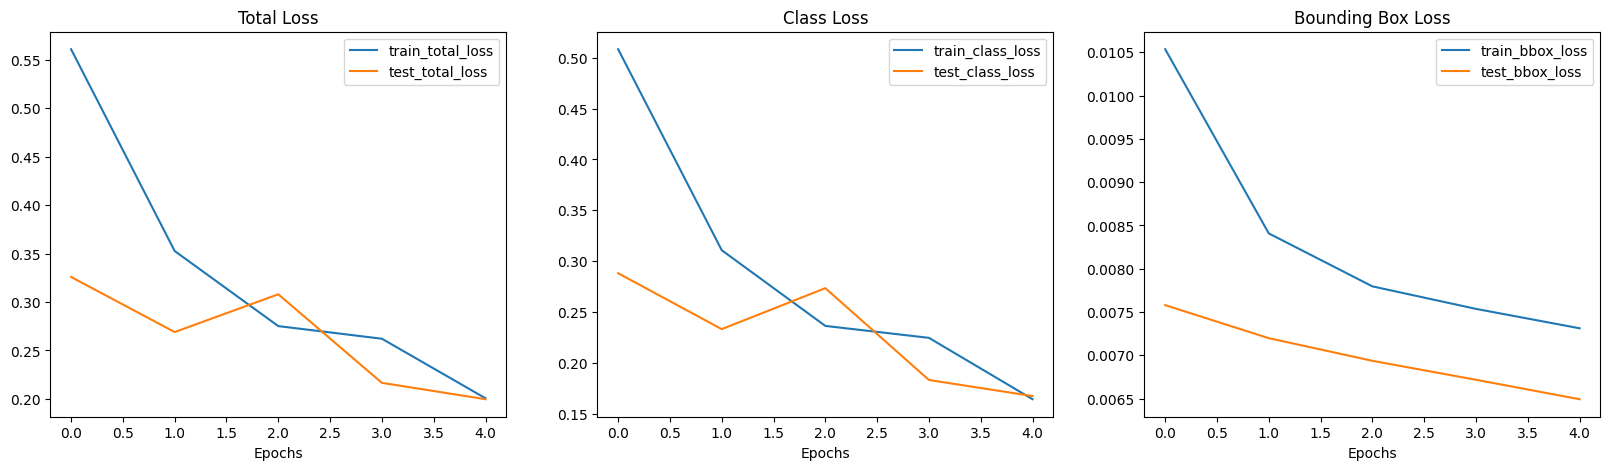

In [31]:
plot_loss_curves(results)

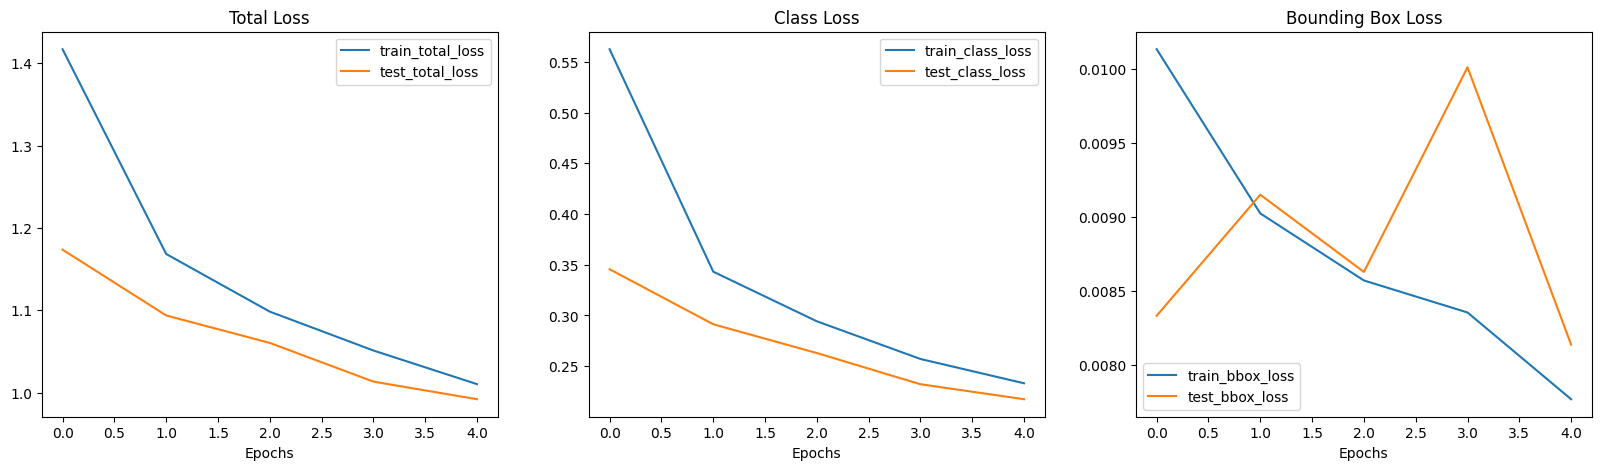

In [33]:
plot_loss_curves(improv_results)

## Evaluation:

In [36]:
def calculate_iou(box1, box2) -> Any:
    # Convert to numpy if needed
    if hasattr(box1, "cpu"):
        box1 = box1.cpu().numpy()
    if hasattr(box2, "cpu"):
        box2 = box2.cpu().numpy()

    # Convert center format to corner format
    box1_x1, box1_y1 = box1[0] - box1[2] / 2, box1[1] - box1[3] / 2
    box1_x2, box1_y2 = box1[0] + box1[2] / 2, box1[1] + box1[3] / 2
    box2_x1, box2_y1 = box2[0] - box2[2] / 2, box2[1] - box2[3] / 2
    box2_x2, box2_y2 = box2[0] + box2[2] / 2, box2[1] + box2[3] / 2

    # Intersection
    inter_x1, inter_y1 = max(box1_x1, box2_x1), max(box1_y1, box2_y1)
    inter_x2, inter_y2 = min(box1_x2, box2_x2), min(box1_y2, box2_y2)
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    # Union
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area

    return inter_area / (union_area + 1e-6)


def evaluate_detection_model(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device,
    class_names: List[str],
    iou_thresholds: List[float] = [0.3, 0.5, 0.7],
    confidence_threshold: float = 0.1,
    verbose: bool = True,
) -> Dict[str, float]:
    """
    Comprehensive evaluation function for object detection model

    Args:
        model: The detection model to evaluate
        dataloader: DataLoader containing validation/test data
        device: Device to run evaluation on
        class_names: List of class names
        iou_thresholds: List of IoU thresholds to evaluate at
        confidence_threshold: Minimum confidence to consider a detection
        verbose: Whether to print detailed results

    Returns:
        Dictionary containing evaluation metrics
    """
    model.eval()

    # Initialize metrics
    total_samples = 0
    correct_classifications = 0

    # IoU-based metrics for different thresholds
    iou_metrics = {f"bbox_acc_iou_{thresh}": 0 for thresh in iou_thresholds}
    iou_scores_all = []

    # Per-class metrics
    class_correct = {i: 0 for i in range(len(class_names))}
    class_total = {i: 0 for i in range(len(class_names))}
    class_iou_scores = {i: [] for i in range(len(class_names))}

    # Confidence and error analysis
    confidence_scores = []
    prediction_errors = []

    if verbose:
        print("Starting evaluation...")
        dataloader = tqdm(dataloader, desc="Evaluating")

    with torch.inference_mode():
        for batch_idx, batch in enumerate(dataloader):
            pixel_values = batch["pixel_values"].to(device)
            labels_batch = batch["labels"]

            # Get model predictions
            outputs = model(pixel_values)
            class_logits = outputs["class_logits"]  # [batch, num_classes]
            bbox_preds = outputs["bbox_preds"]  # [batch, 4]

            # Convert to probabilities and get predictions
            class_probs = torch.softmax(class_logits, dim=-1)
            predicted_classes = torch.argmax(class_probs, dim=-1)
            max_confidences = torch.max(class_probs, dim=-1)[0]

            batch_size = len(labels_batch)
            total_samples += batch_size

            for i in range(batch_size):
                # Ground truth
                gt_label = labels_batch[i][0]  # First (and only) object
                gt_class = gt_label["class_id"]
                gt_bbox = torch.tensor(gt_label["bbox"])

                # Predictions
                pred_class = predicted_classes[i].item()
                pred_bbox = bbox_preds[i]
                confidence = max_confidences[i].item()

                # Store confidence scores
                confidence_scores.append(confidence)

                # Classification accuracy
                class_total[gt_class] += 1
                if pred_class == gt_class:
                    correct_classifications += 1
                    class_correct[gt_class] += 1

                # Only evaluate bounding box if confidence is above threshold
                if confidence >= confidence_threshold:
                    # Calculate IoU
                    iou_score = calculate_iou(pred_bbox, gt_bbox)
                    iou_scores_all.append(iou_score)
                    class_iou_scores[gt_class].append(iou_score)

                    # Check IoU at different thresholds
                    for thresh in iou_thresholds:
                        if iou_score >= thresh:
                            iou_metrics[f"bbox_acc_iou_{thresh}"] += 1
                else:
                    # Low confidence predictions get 0 IoU
                    iou_scores_all.append(0.0)
                    class_iou_scores[gt_class].append(0.0)

                # Store prediction errors for analysis
                prediction_errors.append(
                    {
                        "gt_class": gt_class,
                        "pred_class": pred_class,
                        "confidence": confidence,
                        "iou": iou_scores_all[-1],
                        "gt_bbox": gt_bbox.numpy(),
                        "pred_bbox": pred_bbox.cpu().numpy(),
                    }
                )

    # Calculate final metrics
    classification_accuracy = correct_classifications / total_samples
    mean_iou = np.mean(iou_scores_all) if iou_scores_all else 0.0

    # Normalize IoU-based accuracies
    for key in iou_metrics:
        iou_metrics[key] = iou_metrics[key] / total_samples

    # Per-class accuracies
    class_accuracies = {}
    class_mean_ious = {}
    for i in range(len(class_names)):
        if class_total[i] > 0:
            class_accuracies[class_names[i]] = class_correct[i] / class_total[i]
            class_mean_ious[class_names[i]] = np.mean(class_iou_scores[i]) if class_iou_scores[i] else 0.0
        else:
            class_accuracies[class_names[i]] = 0.0
            class_mean_ious[class_names[i]] = 0.0

    # Confidence analysis
    mean_confidence = np.mean(confidence_scores)
    high_conf_samples = sum(1 for conf in confidence_scores if conf > 0.8)
    low_conf_samples = sum(1 for conf in confidence_scores if conf < 0.3)

    # Compile results
    results = {
        "classification_accuracy": classification_accuracy,
        "mean_iou": mean_iou,
        "mean_confidence": mean_confidence,
        "high_confidence_samples": high_conf_samples / total_samples,
        "low_confidence_samples": low_conf_samples / total_samples,
        **iou_metrics,
        "class_accuracies": class_accuracies,
        "class_mean_ious": class_mean_ious,
        "total_samples": total_samples,
    }

    if verbose:
        print("\n" + "=" * 60)
        print("EVALUATION RESULTS")
        print("=" * 60)
        print(f"Total samples: {total_samples}")
        print(f"Classification Accuracy: {classification_accuracy:.3f} ({correct_classifications}/{total_samples})")
        print(f"Mean IoU: {mean_iou:.3f}")
        print(f"Mean Confidence: {mean_confidence:.3f}")

        print("\nBounding Box Accuracy at different IoU thresholds:")
        for thresh in iou_thresholds:
            acc = iou_metrics[f"bbox_acc_iou_{thresh}"]
            count = int(acc * total_samples)
            print(f"  IoU ≥ {thresh}: {acc:.3f} ({count}/{total_samples})")

        print("\nPer-class Classification Accuracy:")
        for class_name in class_names:
            acc = class_accuracies[class_name]
            total_class = class_total[class_names.index(class_name)]
            correct_class = class_correct[class_names.index(class_name)]
            print(f"  {class_name}: {acc:.3f} ({correct_class}/{total_class})")

        print("\nPer-class Mean IoU:")
        for class_name in class_names:
            iou = class_mean_ious[class_name]
            print(f"  {class_name}: {iou:.3f}")

        print("\nConfidence Analysis:")
        print(
            f"  High confidence (>0.8): {high_conf_samples}/{total_samples} ({high_conf_samples / total_samples:.1%})"
        )
        print(f"  Low confidence (<0.3): {low_conf_samples}/{total_samples} ({low_conf_samples / total_samples:.1%})")

        # Find worst predictions for debugging
        worst_predictions = sorted(prediction_errors, key=lambda x: x["iou"])[:5]
        print("\nWorst 5 predictions (lowest IoU):")
        for i, pred in enumerate(worst_predictions):
            gt_name = class_names[pred["gt_class"]]
            pred_name = class_names[pred["pred_class"]]
            print(
                f"  {i + 1}. GT: {gt_name}, Pred: {pred_name}, Conf: {pred['confidence']:.3f}, IoU: {pred['iou']:.3f}"
            )

    return results


In [40]:
def compare_models(
    model1: torch.nn.Module,
    model2: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device,
    class_names: List[str],
    model1_name: str = "Model 1",
    model2_name: str = "Model 2",
) -> None:
    """Compare two models side by side"""

    print(f"Evaluating {model1_name}...")
    results1 = evaluate_detection_model(model1, dataloader, device, class_names)

    print(f"\nEvaluating {model2_name}...")
    results2 = evaluate_detection_model(model2, dataloader, device, class_names)

    # Create comparison
    print("\n" + "=" * 80)
    print("MODEL COMPARISON")
    print("=" * 80)
    print(f"{'Metric':<30} {model1_name:<15} {model2_name:<15} {'Difference':<15}")
    print("-" * 80)

    metrics_to_compare = [
        "classification_accuracy",
        "mean_iou",
        "bbox_acc_iou_0.5",
        "bbox_acc_iou_0.3",
        "mean_confidence",
    ]

    for metric in metrics_to_compare:
        val1 = results1[metric]
        val2 = results2[metric]
        diff = val2 - val1
        diff_str = f"+{diff:.3f}" if diff > 0 else f"{diff:.3f}"
        print(f"{metric:<30} {val1:<15.3f} {val2:<15.3f} {diff_str:<15}")

    print("-" * 80)

    # Determine winner
    score1 = (results1["classification_accuracy"] + results1["mean_iou"]) / 2
    score2 = (results2["classification_accuracy"] + results2["mean_iou"]) / 2

    if score2 > score1:
        print(f"🏆 {model2_name} performs better (combined score: {score2:.3f} vs {score1:.3f})")
    elif score1 > score2:
        print(f"🏆 {model1_name} performs better (combined score: {score1:.3f} vs {score2:.3f})")
    else:
        print(f"🤝 Models perform equally (combined score: {score1:.3f})")


compare_models(
    detection_model,
    improved_model,
    test_dataloader,
    device,
    CLASSES_NAMES,
    model1_name="DINOv2YOLO",
    model2_name="SpatialDINOv2YOLO",
)

Evaluating DINOv2YOLO...
Starting evaluation...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


EVALUATION RESULTS
Total samples: 308
Classification Accuracy: 0.948 (292/308)
Mean IoU: 0.155
Mean Confidence: 0.925

Bounding Box Accuracy at different IoU thresholds:
  IoU ≥ 0.3: 0.201 (62/308)
  IoU ≥ 0.5: 0.045 (14/308)
  IoU ≥ 0.7: 0.006 (2/308)

Per-class Classification Accuracy:
  glioma: 0.943 (150/159)
  meningioma: 0.935 (58/62)
  pituitary: 0.966 (84/87)

Per-class Mean IoU:
  glioma: 0.134
  meningioma: 0.070
  pituitary: 0.254

Confidence Analysis:
  High confidence (>0.8): 269/308 (87.3%)
  Low confidence (<0.3): 0/308 (0.0%)

Worst 5 predictions (lowest IoU):
  1. GT: meningioma, Pred: meningioma, Conf: 0.858, IoU: 0.000
  2. GT: meningioma, Pred: meningioma, Conf: 0.753, IoU: 0.000
  3. GT: pituitary, Pred: pituitary, Conf: 0.958, IoU: 0.000
  4. GT: meningioma, Pred: meningioma, Conf: 0.912, IoU: 0.000
  5. GT: pituitary, Pred: pituitary, Conf: 0.524, IoU: 0.000

Evaluating SpatialDINOv2YOLO...
Starting evaluation...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


EVALUATION RESULTS
Total samples: 308
Classification Accuracy: 0.925 (285/308)
Mean IoU: 0.232
Mean Confidence: 0.886

Bounding Box Accuracy at different IoU thresholds:
  IoU ≥ 0.3: 0.351 (108/308)
  IoU ≥ 0.5: 0.130 (39/308)
  IoU ≥ 0.7: 0.019 (6/308)

Per-class Classification Accuracy:
  glioma: 0.918 (146/159)
  meningioma: 0.871 (54/62)
  pituitary: 0.977 (85/87)

Per-class Mean IoU:
  glioma: 0.190
  meningioma: 0.112
  pituitary: 0.394

Confidence Analysis:
  High confidence (>0.8): 236/308 (76.6%)
  Low confidence (<0.3): 0/308 (0.0%)

Worst 5 predictions (lowest IoU):
  1. GT: meningioma, Pred: meningioma, Conf: 0.447, IoU: 0.000
  2. GT: pituitary, Pred: pituitary, Conf: 0.930, IoU: 0.000
  3. GT: meningioma, Pred: meningioma, Conf: 0.797, IoU: 0.000
  4. GT: meningioma, Pred: meningioma, Conf: 0.768, IoU: 0.000
  5. GT: glioma, Pred: glioma, Conf: 0.993, IoU: 0.000

MODEL COMPARISON
Metric                         DINOv2YOLO      SpatialDINOv2YOLO Difference     
-----------

## Save Model:

In [ ]:
def save_model(model: torch.nn.Module, dir: Path, model_name: str) -> None:
    """Saves a PyTorch model to a target directory.

    Args:
      model: A target PyTorch model to save.
      target_dir: A directory for saving the model to.
      model_name: A filename for the saved model. Should include
        either ".pth" or ".pt" as the file extension.
    """
    # Create target directory
    dir.mkdir(parents=True, exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = dir / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)


# Save the model
save_model(improved_model, dir=Path("../models"), model_name="spatial_dinov2_yolo.pth")

## Inference:

In [ ]:
# Explore classes and coordinates
def get_image_label_info(labels_file: Path) -> Tuple[str, List[float]]:
    with open(labels_file, "r") as f:
        lines = f.readlines()

    labels = []
    for line in lines:
        entries = line.strip().split()
        # Extract class id (first entry)
        class_id = int(entries[0])

        # Coordinates are in pairs: x1, y1, x2, y2, ..., xn, yn
        coordinates = [float(i) for i in entries[1:]]
        x_coords = coordinates[::2]
        y_coords = coordinates[1::2]

        # Get bounding box from polygon
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)

        # Convert to center format
        cx = (x_min + x_max) / 2
        cy = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min

        labels.append(
            {"class_id": class_id, "bbox": [cx, cy, width, height], "vertices": list(zip(x_coords, y_coords))}
        )

    return labels


def predict_and_plot(
    model: torch.nn.Module,
    image_path: Path,
    label_path: Path,
    class_names: List[str],
    processor=processor,
    device: torch.device = device,
    confidence_threshold: float = 0.5,
) -> None:
    """Makes a prediction on a target image with a target model and plots the results."""
    img = Image.open(image_path)
    original_size = img.size
    model.eval()

    with torch.inference_mode():
        processed_input = processor(images=img, return_tensors="pt")
        pixel_values = processed_input["pixel_values"].to(device)
        outputs = model(pixel_values)

    # Extract predictions
    class_logits = outputs["class_logits"].squeeze(0)  # [num_classes]
    bbox_preds = outputs["bbox_preds"].squeeze(0)  # [4]

    # Get class prediction
    class_probs = torch.softmax(class_logits, dim=-1)
    predicted_class = torch.argmax(class_probs)
    confidence = class_probs[predicted_class].item()

    # Load original image and labels
    labels = get_image_label_info(label_path)
    actual_class, actual_vertices = labels[0]["class_id"], labels[0]["vertices"]

    print(f"Predicted class: {class_names[predicted_class]} (confidence: {confidence:.3f})")
    print(f"Actual class: {class_names[actual_class]}")
    print(f"Bounding box: {bbox_preds.cpu().numpy()}")

    # Visualize if confidence is above threshold
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    ax.set_title(f"Predicted Detection: {class_names[predicted_class]} ({confidence:.3f})")
    ax.axis("off")

    if confidence > confidence_threshold:
        # Draw real polygon
        # Scale coordinates to image size
        x_coords = [vertice[0] * original_size[0] for vertice in actual_vertices]
        y_coords = [vertice[1] * original_size[1] for vertice in actual_vertices]

        # Create polygon patch
        polygon_points = list(zip(x_coords, y_coords))
        polygon = patches.Polygon(polygon_points, linewidth=2, edgecolor="red", facecolor="red", alpha=0.3, closed=True)
        ax.add_patch(polygon)

        # Convert normalized bbox to pixel coordinates
        cx, cy, w, h = bbox_preds.cpu().numpy()
        cx_pixel = cx * original_size[0]
        cy_pixel = cy * original_size[1]
        w_pixel = w * original_size[0]
        h_pixel = h * original_size[1]

        x_min = cx_pixel - w_pixel / 2
        y_min = cy_pixel - h_pixel / 2

        # Draw bounding box
        rect = patches.Rectangle(
            (x_min, y_min), w_pixel, h_pixel, linewidth=3, edgecolor="yellow", facecolor="none", linestyle="--"
        )
        ax.add_patch(rect)

        # Add label
        ax.text(
            x_min,
            y_min - 10,
            f"{class_names[predicted_class]}: {confidence:.2f}",
            color="yellow",
            fontsize=12,
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.5),
        )

    plt.show()

Predicted class: pituitary (confidence: 0.919)
Actual class: pituitary
Bounding box: [0.6516854  0.4997904  0.16309936 0.15591682]


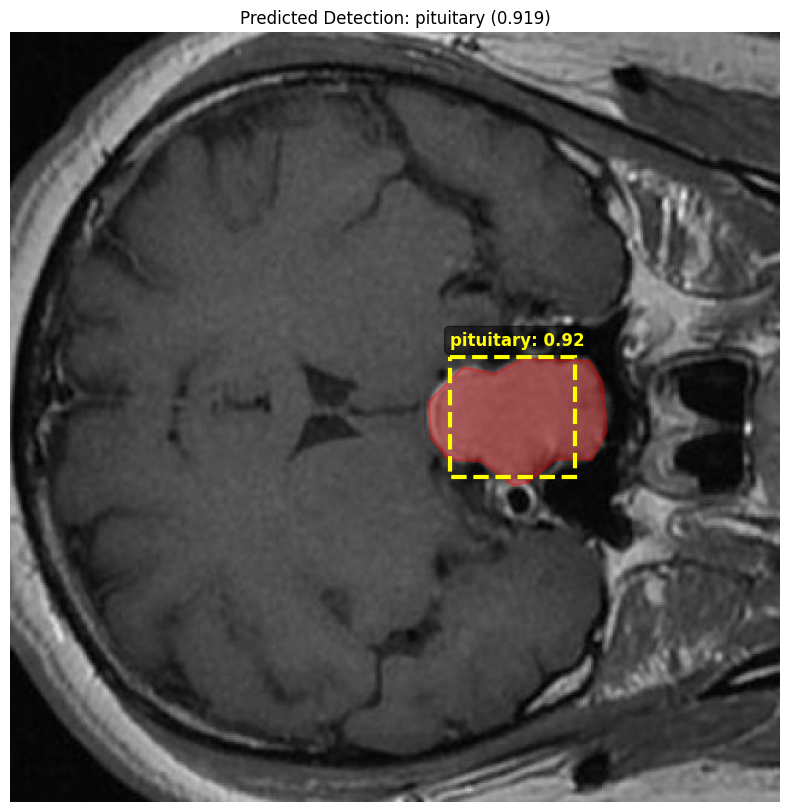

In [74]:
# Predict on validation dataset
images_path = valid_path / "images"
images = list(images_path.glob("*.jpg"))
sample = random.choice(images)
image_name = sample.stem
split = "valid"

predict_and_plot(
    model=improved_model,
    image_path=sample,
    label_path=valid_path / "labels" / f"{image_name}.txt",
    class_names=CLASSES_NAMES,
    confidence_threshold=0.5,  # Lower threshold for medical imaging
)